In [113]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
from scipy.optimize import curve_fit
from scipy import optimize
import sys,os, os.path,shutil
import glob
from reshape import *
from fit import *
from lmfit import Model
from lmfit.models import GaussianModel,LinearModel

In [114]:
def plot(img,radius_x,radius_y,distance=0.05,detail=0):

    x_x,x_line,y_y,y_line = info(img)
    
    fig=plt.figure(figsize=(9.75,10))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    #left graph --------------------------------

    ax1 = plt.subplot(221)

    plt.grid(True, linestyle = "-.", color = "grey", linewidth = "0.5")
    plt.ylabel('distance_x mm')
    plt.xlabel('power [arb.unit]')
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    
    y_y=np.arange(len(y_line))
    plt.xlim(0,100)
    plt.ylim(len(y_y)*5.2/1000,0)
    plt.scatter(y_line/255*100,y_y*5.2/1000,s=1,c="b",alpha=0.5) 
    
    #bottom graph --------------------------------

    ax2 = plt.subplot(224)
    
    plt.grid(True, linestyle = "-.", color = "grey", linewidth = "0.5")
    plt.xlabel('distance_y mm')
    plt.ylabel('power [arb.unit]')
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position('right') 
    
    x_x=np.arange(len(x_line))
    plt.xlim(0,len(x_x)*5.2/1000)
    plt.ylim(0,100)
    plt.scatter(x_x*5.2/1000,x_line/255*100,s=1,c="b",alpha=0.5)

    #image --------------------------------

    ax0 = plt.subplot(222,aspect='auto')
    cax=plt.imshow(img/255*100,cmap=plt.cm.inferno)
    plt.axis('off')
    
    #colourbar ----------------------------
    cbar_ax = fig.add_axes([0.92, 0.52, 0.02, 0.36])
    fig.colorbar(cax, cax=cbar_ax)
    
    #slope --------------------------------
    
    radius_x.sort(0)
    radius_y.sort(0)
    
    radius_x = radius_x*5.2/1000
    radius_y = radius_y*5.2/1000
    
    a = np.arange(0,len(radius_x))
    a = a*distance
    
    ax3=plt.subplot(223,aspect='auto')
    
    #plt.ylim(0,a.max())
    plt.grid(True, linestyle = "-.", color = "grey", linewidth = "0.5")
    plt.ylabel('radius mm')
    plt.xlabel('distance mm')
    
    plt.scatter(a,radius_x,s=1,c="r",alpha=1,label='x-axis')
    plt.scatter(a,radius_y,s=1,c="b",alpha=1,label='y-axis')
    
    
    p_line = {
    'a': {'value': 0.2}, 
    'b': {'value': min(x_line)}, 
    }
    
    p_gau = {
    'a': {'value': max(x_line)/2}, 
    'b': {'value': min(x_line)},
    'x0': {'value': len(x_x)/2}, 
    'sigma': {'value': 30},
    }
    
    x_plot,model,out=fit(linear,p_line,a,radius_x)
    ax3.plot(x_plot, model(out.params, x_plot), 'r', alpha = 0.5)
    
    slope1=out.params["a"].value
    stderr1=out.params['a'].stderr
    b1=out.params["b"].value
    
    x_plot,model,out=fit(linear,p_line,a,radius_y)
    ax3.plot(x_plot, model(out.params, x_plot), 'b', alpha = 0.5)
    
    slope2=out.params["a"].value
    stderr2=out.params['a'].stderr
    b2=out.params["b"].value
    
    x_plot,model,out=fit(gaussian,p_gau,x_x,x_line)
    ax2.plot(x_plot*5.2/1000, model(out.params, x_plot)/255*100, 'r',alpha = 0.5)
    
    x_plot,model,out=fit(gaussian,p_gau,y_y,y_line)
    ax1.plot(model(out.params, x_plot)/255*100,x_plot*5.2/1000, 'r',alpha = 0.5)

    plt.legend()
                      
    def w_cal(a,slope,b,radius):     
        zero = -b/slope
        z0 = np.ones(len(a)) - zero
        w = radius*1e-3
        z = (a + z0)
        λ = 850e-9
        w0= np.mean((z*λ)/(3.14*w))*1e6
    
        return w0*5.2/1000,zero
    
    w0_x,zero_x=w_cal(a,slope1,b1,radius_x)
    w0_y,zero_y=w_cal(a,slope2,b2,radius_y)          
        
    degree_x = np.arctan(slope1)/3.14*180
    degree_y = np.arctan(slope2)/3.14*180
    degree_x_stderr = abs((np.arctan(slope1*(1+stderr1))/3.14*180-degree_x)/degree_x)
    degree_y_stderr = abs((np.arctan(slope2*(1+stderr2))/3.14*180-degree_y)/degree_y)
    
#     print(stderr1,stderr2)
#     print(degree_x_stderr,degree_y_stderr)
    
    ax3.text(0.98, 0.02, """
    
    w0_x:%.2f µm, z0_x:%.2f mm
    w0_y:%.2f µm, z0_y:%.2f mm
    X:slope:%.2f, deg:%.2f(stderr %.3f)
    Y:slope:%.2f, deg:%.2f(stderr %.3f)""" %(w0_x,zero_x,w0_y,zero_y,
                                                   slope1,degree_x,stderr1,
                                                   slope2,degree_y,stderr2),
            fontsize=12, horizontalalignment='right',
            verticalalignment='bottom', transform=ax3.transAxes)
    
#     w0_x: %.2f µm , w0_y: %.2f µm
#     z0_x: %.2f mm , z0_y: %.2f mm

In [115]:
filePath = 'Data/300-600/' #input data path
filelst = glob.glob(filePath+'*.bmp')

radius_x=[]
radius_y=[]

am=10000

for files in filelst:
    
    I = imread(files)
    
    img = np.array(I)
    img = reshape(img,lim=20,th=15) 
    #reshape the img by cutting at the 20th(lim=20) pixel whose value below 15(th=15) away from the maximum value pixel.
    
    x_x,x_line,y_y,y_line = info(img)
    
    x_x=np.arange(len(y_line))
    y_y=np.arange(len(y_line))
    
    p_gau = {
    'a': {'value': max(x_line)/2}, 
    'b': {'value': min(x_line)},
    'x0': {'value': len(x_x)/2}, 
    'sigma': {'value': 15},
    }
    
    x_plot,model,out=fit(gaussian,p_gau,x_x,x_line)
    width_x=out.params.get('sigma')*2.3548200*1.699
    x_plot,model,out=fit(gaussian,p_gau,y_y,y_line)
    width_y=out.params.get('sigma')*2.3548200*1.699
    
    radius_x.append(width_x/2)
    radius_y.append(width_y/2)
    
    bp=width_x
    
    if am>bp:
        am=bp
        cap=img
    else:
        pass
    
radius_x=np.array(radius_x)
radius_y=np.array(radius_y)

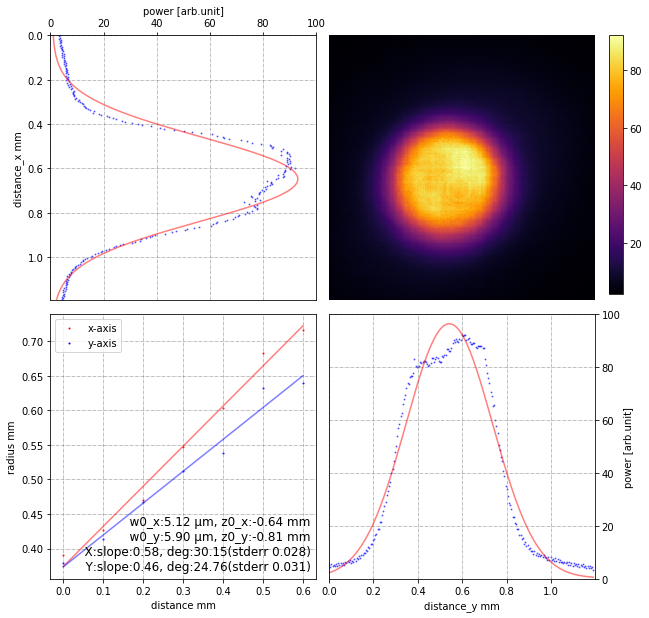

In [116]:
plot(cap,radius_x,radius_y,distance=0.1,detail=0)
# the unit of distance is mm
# this parametere is used to generate the distance array coresponding to each pic. 
# [0,0.1,0.2,0.3,0.4~~~~],[pic0,pic1,pic2,pic4~~~~]
# Please capture pic with equal distance for convience.
# for customized setting, please change the varible a in funcion plot above.

plt.savefig('./300-600.jpg')
plt.show()

#distance = interval(mm) distance between each sample
#detail = the detail info about fitting